# Uncapacitated Facility Location Problem

In [1]:
#
import os
import sys
import time
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

sys.path.append("..")

# Personal modules
from lp.uflp import UFLP
from lp.cflp import CFLP
from lp.telp import TELP

# Linear programming modules
import pulp

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# == Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# == Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# == Clustering
from sklearn.cluster import KMeans
from sklearn_som.som import SOM
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# == Neural Networks
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# == Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


## Load the data

In [2]:
# import the data and parameters and check the data

data_path = "data/"
start_time = time.time()
# ====Parameters==== #
parameters = pd.read_csv(os.path.join(data_path, "parametros.csv"))
# 1. food_per_person_per_day in tons per day
food_per_person_per_day = float(
    parameters.loc[parameters["parametro"] == "comida_por_persona_en_toneladas"].values[
        0
    ][1]
)
# 2. transport_cost_per_ton_per_km in COP per ton per km
transport_cost_per_ton_per_km = float(
    parameters.loc[
        parameters["parametro"] == "costo_de_transporte_por_tonelada_por_kilomentro"
    ].values[0][1]
)

print(
    f"parameters: \n    food_per_person_per_day: {food_per_person_per_day} \n    transport_cost_per_ton_per_km: {transport_cost_per_ton_per_km}\n"
)
# ====Parameters==== #

# ====importData==== #
# 1. population, from data/municipios_procesado.csv
population = pd.read_csv(
    os.path.join(data_path, "municipios_procesado.csv"), index_col=3
)
# 2. distance, from data/distance_matrix_final.csv
distance = pd.read_csv(
    os.path.join(data_path, "distance_matrix_final.csv"), index_col=0
)
# 3. warehouses, from data/almacenes.csv
warehouses = pd.read_csv(os.path.join(data_path, "almacenes.csv"))
# ====importData==== #

# ====DataProcessing===== #
# fill the nan values in population with the minimum '2024' from the departamento of Chocó for the columns 22:
population.loc[population.isna().any(axis=1), population.columns[18:]] = (
    population[
        population["2024"]
        == population.loc[population["departamento"] == "Chocó"]["2024"].min()
    ]
    .iloc[0, 18:]
    .values
)
# drop the municipalities with nan values in the first column of the distance matrix
distance = distance.dropna(subset=[distance.columns[0]], axis=0)
distance = distance.dropna(subset=[distance.index[0]], axis=1)
# select only the rows in population dpmp that the index is in distance
population = population.loc[distance.index]
# turn the columns of distance into integers
distance.columns = distance.columns.astype(int)
print(
    f"data information: \n    population: {population.shape} \n    distance: {distance.shape} \n    warehouses: \n {warehouses} \n"
)
# ====DataProcessing===== #

# ====DataInformation==== #
# Memory usage of the data
print(f"population memory usage: {population.memory_usage().sum()/1024**2:.2f} MB")
print(f"distance memory usage: {distance.memory_usage().sum()/1024**2:.2f} MB")
print(f"warehouses memory usage: {warehouses.memory_usage().sum()/1024**2:.2f} MB")
# ====DataInformation==== #

# ====DataChecking==== #
# Test to the data if needed
# ====DataChecking==== #
print(f"Elapsed time: {time.time() - start_time:.2f} s")


parameters: 
    food_per_person_per_day: 0.00087617 
    transport_cost_per_ton_per_km: 3364.0

data information: 
    population: (1117, 71) 
    distance: (1117, 1117) 
    warehouses: 
    Type  capacity_ton        cost
0     1          1074   731159925
1     2          2418  1129212606
2     3          9672  4516850424 

population memory usage: 0.61 MB
distance memory usage: 9.56 MB
warehouses memory usage: 0.00 MB
Elapsed time: 0.35 s


## 1. Demand Forecast

we are using the data from the population dataset that has the colombian census information since 1985 to 2035, the current year is 2024 and the last census was performed in 2018, the data was taken on december 2023 from the DANE web page.

First we need to check the current forecast, then use 4 ML algorithms and Deep Learning to create a new model. The Machine Learning algorithms are:
- Multiple Linear Regression.
- Regression Tree.
- Support Vector Machine.
- Random Forest Regression.

Then, we need the Mean Absolute Error (MAE) to compare the models. The best model will be used to forecast the demand for the next 30 years.

In [8]:
# ## 1. Demand Forecast

# 1. Demand Forecast
data = population.copy().iloc[:, 20:]
data = data.transpose()

# Standardize the data
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=0)

# List of models to evaluate
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Regression Tree": DecisionTreeRegressor(
        max_depth=10, min_samples_split=2, min_samples_leaf=1
    ),
    "Support Vector Machine": SVR(C=1.0, kernel="rbf", gamma="scale"),
    "Random Forest Regression": RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1
    ),
}

best_model = None
best_score = float("-inf")
results = {}

# Iterate over models
for model_name, model in models.items():
    start_time = time.time()
    mean_absolute_errors = []
    mean_squared_errors = []
    r2_scores = []

    # For each column in the data
    for column in data.columns:
        model.fit(train.index.values.reshape(-1, 1), train[column])
        predictions = model.predict(test.index.values.reshape(-1, 1))
        mean_absolute_errors.append(mean_absolute_error(test[column], predictions))
        mean_squared_errors.append(mean_squared_error(test[column], predictions))
        r2_scores.append(r2_score(test[column], predictions))

    avg_r2_score = np.mean(r2_scores)
    results[model_name] = {
        "time": time.time() - start_time,
        "mean_absolute_error": np.mean(mean_absolute_errors),
        "mean_squared_error": np.mean(mean_squared_errors),
        "r2_score": avg_r2_score,
    }

    if avg_r2_score > best_score:
        best_score = avg_r2_score
        best_model = model

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics['time']:.2f} s")
    print(f"    Mean Absolute Error: {metrics['mean_absolute_error']}")
    print(f"    Mean Squared Error: {metrics['mean_squared_error']}")
    print(f"    R2 Score: {metrics['r2_score']}")

print(f"\nBest model: {best_model}")


# Predict for a specific index
def predict_for_index(index, model=best_model):
    predictions = {}
    for column in data.columns:
        model.fit(data_scaled.index.values.reshape(-1, 1), data_scaled[column])
        predictions[column] = model.predict([[index]])[0]

    # Convert predictions dictionary to DataFrame
    predictions_df = pd.DataFrame.from_dict(
        predictions, orient="index", columns=[index]
    )

    # Inverse transform the predictions to original scale
    predictions_df = scaler.inverse_transform(predictions_df.values)
    predictions_df = pd.DataFrame(predictions_df, index=data.columns, columns=[index])

    return predictions_df


# Example usage
index_to_predict = 2034
predictions = predict_for_index(index_to_predict)
if predictions is not None:
    print(f"Predictions for the year {index_to_predict}:")
    display(predictions)


Multiple Linear Regression: 4.83 s
    Mean Absolute Error: 0.428457750684778
    Mean Squared Error: 0.3664370666800922
    R2 Score: 0.5860169997999521
Regression Tree: 4.39 s
    Mean Absolute Error: 0.09093062070801274
    Mean Squared Error: 0.032517679104043365
    R2 Score: 0.9672813069578106
Support Vector Machine: 4.52 s
    Mean Absolute Error: 0.10992893224062007
    Mean Squared Error: 0.05873704491266884
    R2 Score: 0.9431877181416908
Random Forest Regression: 247.78 s
    Mean Absolute Error: 0.05794851893894632
    Mean Squared Error: 0.01969566234333563
    R2 Score: 0.9806757353474495

Best model: RandomForestRegressor(max_depth=10)


NameError: name 'data_scaled' is not defined

## 2. Set facility types

We have 3 types of facilities:
- Type 1: Small facility.
- Type 2: Medium facility.
- Type 3: Large facility.

for each facility type we have the following information:
- Fixed cost.
- Variable cost.

The proposal is to use a mathematical model to determine the number of facilities of each type to minimize the total cost, in order to satisfy the demand. and be able to train a classifier to predict the type of facility that will be needed for the hole country.

### Model

#### Sets
- $I$: Set of municipalities.
- $J$: Types of facilities.

#### Parameters
- $c_{j}$: Capacity of facility type $j$.
- $f_{j}$: Fixed cost of facility type $j$.

- $p_{i}$: Population of municipality $i$.
- $N$: Food Demand per capita in Tonnes.
- $d_{i}$: Demand of municipality $i$ = $p_{i} * N$.
- $r_{i}$: department aggregation of population of municipality $i$.
- $\lambda_{i}$: Multiplier of demand of municipality based on its department population.$

#### Decision Variables
- $x_{ij}$: Number of facilities of type $j$ in municipality $i$.

#### Objective Function
- Minimize the total cost of the facilities.

$$ \text{Min} \sum_{i \in I} \sum_{j \in J} f_{j} * x_{ij} $$

#### Constraints

- Demand constraint: The demand of municipality $i$ must be satisfied.

$$ \sum_{j \in J} x_{ij} * c_{j} \geq d_{i} * \lambda_{i} \quad \forall i \in I $$

- (optional) General capacity:

$$ \sum_{i \in I} \sum_{j \in J} x_{ij} * c_{j} \leq \sum_{i \in I} d_{i} * \lambda_{i} $$

- Non-negativity:

$$ x_{ij} \geq 0 \quad \forall i \in I, \forall j \in J $$

- Integer:

$$ x_{ij} \in \mathbb{Z} \quad \forall i \in I, \forall j \in J $$



In [4]:
# Optimization of the model
p = population["2024"].sample(frac=0.85, random_state=5)


# ====Parameters==== #
c_j = warehouses["capacity_ton"].values.astype(float)
f_j = warehouses["cost"].values.astype(float)


p_i = p.values.astype(int)
n = food_per_person_per_day * 7
d_i = p_i * n
# Lambda = 2 for the top 32 municipalities, 1 for the rest
lambda_i = np.ones(len(p_i)) * 1.1
lambda_i[np.argsort(p_i)[-32:]] = 1.5
# ====Parameters==== #


# Decision variables: $x_{ij}$
I = range(len(p_i))
J = range(len(c_j))
model = pulp.LpProblem("UFLP", pulp.LpMinimize)
x = pulp.LpVariable.dicts(
    "x", ((i, j) for i in I for j in J), lowBound=0, cat="Integer"
)
y = pulp.LpVariable.dicts("y", ((i, j) for i in I for j in J), cat="Binary")
# Objective function
model += (
    pulp.lpSum(f_j[j] * x[(i, j)] for i in I for j in J),
    "Total cost of the facilities",
)
# Constraints
for i in I:
    model += (
        pulp.lpSum(c_j[j] * x[(i, j)] for j in J) >= d_i[i] * lambda_i[i],
        f"Population demand {i}",
    )
    model += (
        pulp.lpSum(x[(i, j)] for j in J) >= 1,
        f"Facility assignment {i}",
    )
    model += (
        pulp.lpSum(y[(i, j)] for j in J) == 1,
        f"Faacility assignment __ {i}",
    )
    for j in J:
        model += (
            x[(i, j)] <= 100 * y[(i, j)],
            f"Fsacility assignment _ {i} _ {j}",
        )


model += pulp.lpSum(x[(i, j)] * c_j[j] for i in I for j in J) >= pulp.lpSum(
    d_i[i] * lambda_i[i] for i in I
)


# Solve the model
model.solve()
# Results
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Objective function: {pulp.value(model.objective)}")
df = pd.DataFrame(
    [[pulp.value(x[(i, j)]) for j in J] for i in I],
    columns=[f"Facility {j}" for j in J],
    index=p.index,
)
df["demand"] = d_i
df["satisfied"] = sum(df[f"Facility {j}"] * c_j[j] for j in J)
df["cost"] = sum(df[f"Facility {j}"] * f_j[j] for j in J)
df["comb"] = df.apply(lambda x: tuple(x[: len(J)]), axis=1)

display(df.comb.unique().size, df.comb.unique())
display(df)


Status: Optimal
Objective function: 811097283420.0


11

array([(1.0, 0.0, 0.0), (0.0, 0.0, 1.0), (0.0, 3.0, 0.0),
       (0.0, 31.0, 0.0), (3.0, 0.0, 0.0), (0.0, 1.0, 0.0),
       (0.0, 6.0, 0.0), (0.0, 9.0, 0.0), (0.0, 2.0, 0.0), (0.0, 5.0, 0.0),
       (0.0, 10.0, 0.0)], dtype=object)

,Facility 0,Facility 1,Facility 2,demand,satisfied,cost,comb
dpmp,,,,,,,
25781,1.0,0.0,0.0,43.932040,1074.0,731159925.0,"(1.0, 0.0, 0.0)"
47318,1.0,0.0,0.0,186.166849,1074.0,731159925.0,"(1.0, 0.0, 0.0)"
27073,1.0,0.0,0.0,72.635369,1074.0,731159925.0,"(1.0, 0.0, 0.0)"
25258,1.0,0.0,0.0,33.793877,1074.0,731159925.0,"(1.0, 0.0, 0.0)"
19142,1.0,0.0,0.0,193.514411,1074.0,731159925.0,"(1.0, 0.0, 0.0)"
...,...,...,...,...,...,...,...
50590,1.0,0.0,0.0,84.834284,1074.0,731159925.0,"(1.0, 0.0, 0.0)"
47960,1.0,0.0,0.0,67.673618,1074.0,731159925.0,"(1.0, 0.0, 0.0)"
5147,1.0,0.0,0.0,320.054387,1074.0,731159925.0,"(1.0, 0.0, 0.0)"


## 3. Set facility capacity

We have m types of facilities with different capacities, the proposal is to use the data generated in the previous step to determine the capacity of each facility type in order to satisfy the demand.
Machine Learning algorithms will be used to Classify the type of facility that will be needed for each municipality.
- Decision Tree.
- Linear Discriminant Analysis.
- Logistic Regression.
- Support Vector Machine.

and deep learning to create a new model. The best model will be used to determine the capacity of each facility type.

The objective is to predict 'comb' with the information of 'demand', 'lat', 'lon', and 'dp'.


In [9]:
data = pd.merge(df.copy(), population.copy(), left_index=True, right_index=True)
# drop rows with nan in the 'comb' column
data = data.dropna(subset=["comb"])
# train with a random sample of 80% of the data
# The objective is to predict 'comb' with the information of 'demand', 'lat', 'lon', and 'dp'.
# Convert 'comb' to string and encode it
data["comb"] = data["comb"].apply(lambda x: str(x))
data["comb"] = LabelEncoder().fit_transform(data["comb"])

# Standardize the selected features
data[["demand", "lat", "lon", "dp"]] = StandardScaler().fit_transform(
    data[["demand", "lat", "lon", "dp"]]
)

# Split the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(
    data[["demand", "lat", "lon", "dp"]], data["comb"], test_size=0.2, random_state=0
)

# Define and evaluate models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(),
    "Neural Network": MLPClassifier(max_iter=1000, tol=1e-4),
}

best_model = None
best_accuracy = 0
results = {}


def evaluate_model(model_name, model):
    global best_model, best_accuracy
    start_time = time.time()
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    elapsed_time = time.time() - start_time

    results[model_name] = {
        "accuracy": accuracy,
        "confusion_matrix": confusion_matrix(test_y, predictions),
        "classification_report": classification_report(
            test_y, predictions, zero_division=1
        ),
        "time": elapsed_time,
    }

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


for model_name, model in models.items():
    evaluate_model(model_name, model)

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics['time']:.2f} s")
    print(f"    Accuracy: {metrics['accuracy']}")
    print(f"    Confusion Matrix: \n {metrics['confusion_matrix']}")
    print(f"    Classification Report: \n {metrics['classification_report']}")

print(f"\nBest model: {best_model}")


Decision Tree: 0.01 s
    Accuracy: 1.0
    Confusion Matrix: 
 [[  2   0   0   0   0]
 [  0   1   0   0   0]
 [  0   0   2   0   0]
 [  0   0   0 184   0]
 [  0   0   0   0   1]]
    Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           9       1.00      1.00      1.00       184
          10       1.00      1.00      1.00         1

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190

Linear Discriminant Analysis: 0.01 s
    Accuracy: 0.9842105263157894
    Confusion Matrix: 
 [[  2   0   0   0   0]
 [  0   1   0   0   0]
 [  0   0   2   0   0]
 [  3   0   0 181   0]
 [  0   0   0   0   1]]
    Classification Report: 
               precision    recall  f1-score   support

        

## 4. Propose a k parameter for clustering using Linear Programming

The proposal is to use the data generated in the previous step to determine the number of clusters that will be needed to satisfy the demand. The objective is to minimize the total cost of the facilities.


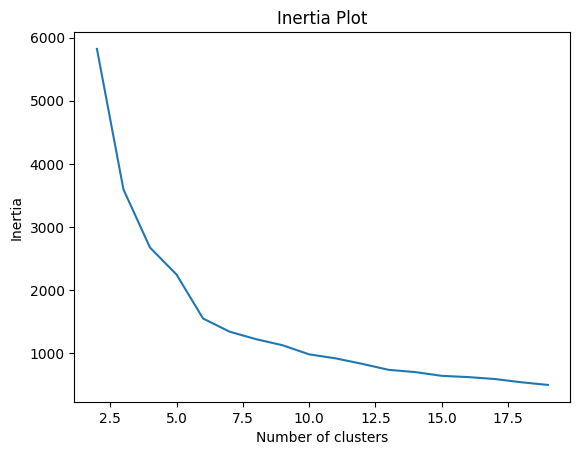

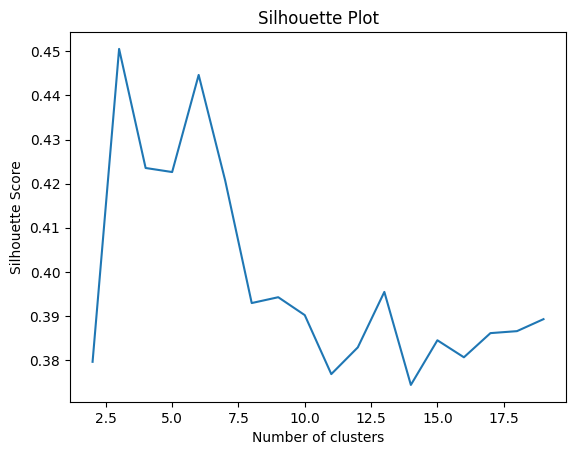

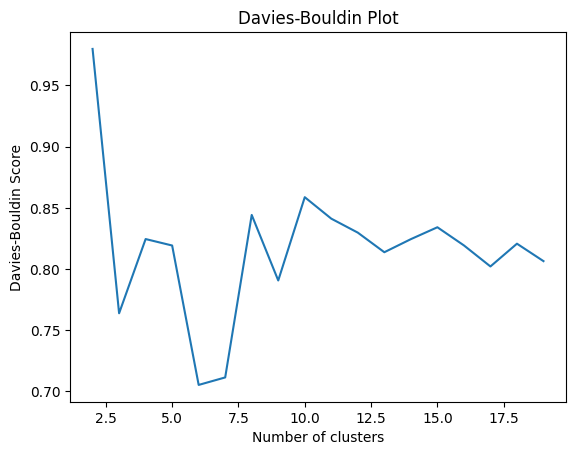

In [6]:
data = population.copy()
distance = distance.loc[data.index, data.index]

# Cluster the data['lat', 'lon'] with the KMeans algorithm
# Proposed number of clusters
# Check the inertia, the Silhouette plot, and the Davies-Bouldin score

# Inertia
inertia = []
silhouette = []
davies_bouldin = []
for i in range(2, 20):
    model = KMeans(n_clusters=i)
    model.fit(data[["lat", "lon"]])
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(data[["lat", "lon"]], model.labels_))
    davies_bouldin.append(davies_bouldin_score(data[["lat", "lon"]], model.labels_))

# Inertia plot
plt.plot(range(2, 20), inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Inertia Plot")
plt.show()

# Silhouette plot
plt.plot(range(2, 20), silhouette)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Plot")
plt.show()

# Davies-Bouldin score
plt.plot(range(2, 20), davies_bouldin)
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin Score")
plt.title("Davies-Bouldin Plot")
plt.show()

# The best number of clusters is 3
